In [22]:
import numpy as np
import pandas as pd
from data.data_preprocess import generate_classification_dataset, generate_core_train_test_by_equipartition, write_file, generate_classification_dataset_by_equipartition, json_to_csv
import openai
import json
import os
from openai.cli import FineTune
import sys
import matplotlib.pyplot as plt
from gpt_attacker import Attacker
import math
import re
import copy
from utils import replace_smiles_with_missing
import chemprop
import tqdm
from io import StringIO
from utils import SMART_LIST
import warnings

openai.api_key = 'PLEASE USE YOUR OWN OPENAI API KEY HERE'

# 1. Data Preprocess

## Troisi dataset (small molecules) generation

In [3]:
splits = [2, 4, 6, 8]
trials = 3
datasets = ['HOMO', 'LUMO']
df = pd.read_csv('./data/CSD_EES_DB.csv')

for dataset in datasets:
    for split in splits:
        for trial in range(trials):
            df_train, df_test = generate_classification_dataset_by_equipartition(column=dataset, df=df, num_class=NUM_CLASS, split=split/10)
            write_file(df_train, df_test, '_{}_{}_{}'.format(str(split/10), dataset, str(trial)))

## SMPs Dataset Generation

In [ ]:
def split(x, num_class):
    if num_class == 3:
        if x < 1.07:
            return 'low'
        elif x < 12.5:
            return 'medium'
        else:
            return 'high'
    elif num_class == 2:
        if x < 1.07:
            return 'low'
        else:
            return 'high'
        
def cut_df(df, n):
    df_num = len(df)
    every_epoch_num = math.floor((df_num/n))
    result = []
    for index in range(n):
        if index < n-1:
            df_tem = df[every_epoch_num * index: every_epoch_num * (index + 1)]
        else:
            df_tem = df[every_epoch_num * index:]
        result.append(df_tem)
    return result

def generate_smps_dataset(num_class=3, k_fold=5):
    df = pd.read_csv('SMPs_572.csv', index_col=0)
    df['completion'] = df.apply(lambda x: split(x['HER (µmol/h)'], num_class), axis=1)
    df = df[['SMILES', 'completion']]
    df.columns = ['prompt', 'completion']
    df['prompt'] = df.apply(lambda row: row['prompt']+'', axis=1)
    result = []
    df = df.sample(frac=1.0)
    completions = set(df['completion'])
    sub_dfs = []
    for i in completions:
        sub_dfs.append(df[df['completion']==i])
        
    results = []
    
    for i in range(k_fold):
        train = pd.DataFrame([])
        test = pd.DataFrame([])
        
        for sub_df in sub_dfs:
            
            sub_df_cut = cut_df(sub_df, k_fold)
            test = pd.concat([test, sub_df_cut[i]])
            del(sub_df_cut[i])
            train = pd.concat([train]+sub_df_cut)
        results.append((train, test))
    return results

a = generate_smps_dataset(2, k_fold=10)

## QMOF dataset generation

In [ ]:
df = pd.read_csv('qmof.csv')
df = df[['qmof_id', 'info.mofid.smiles_nodes', 'info.mofid.smiles_linkers', 'info.mofid.topology']]
df = df.dropna().reset_index()
df['prompt'] = df.apply(lambda x: 'Nodes: '+ ','.join(eval(x['info.mofid.smiles_nodes'])) + ', Linkers: ' + ','.join(eval(x['info.mofid.smiles_linkers'])), axis=1)
df['completion'] = df['info.mofid.topology']
df = df[['prompt', 'completion', 'qmof_id']]
df = df.drop(df[df['completion']=='ERROR,UNKNOWN'].index)

# MOF dataset Drop classes

d = {}
threshold = 10
for index, i in enumerate(set(list(df['completion']))):
    d[i] = index
    di = len(df[df['completion']==i])
    if di < threshold:
        df = df[df['completion']!=i]
print('Class number: ', len(set(list(df['completion']))))

label_counts = df['completion'].value_counts()
valid_labels = label_counts[label_counts > 5].index
df = df[df['completion'].isin(valid_labels)]
print(df['completion'].value_counts())

mapping = {}
for index, i in enumerate(set(list(df['completion']))):
    mapping[i] = index
    
df.to_csv('qmof_info.csv')

In [ ]:
# Generate train and test set

train_index = np.array([])

for topo in set(list(df['completion'])):
    sub_df = df[df['completion']==topo]
    train_num = int(len(sub_df) * SPLIT)
    train_index = np.append(train_index, np.random.choice(sub_df.index, size=train_num, replace=False))
    
df['completion'] = df.apply(lambda x: str(mapping[x['completion']]), axis=1)
df = df[['prompt', 'completion']]
df_train = df.loc[train_index]
df_test = df.append(df_train).drop_duplicates(subset='prompt', keep=False)

df_train.to_csv('mof_train.csv')
df_test.to_csv('mof_test.csv')
with open('mof_class_token_map.json', 'w') as fp:
    json.dump(mapping, fp)
    
write_file(df_train, df_test, 'qmof_topology')

# 2. Experiments

## Troisi dataset

In [10]:
# This script shows the fine-tuning process of one folder (train-validation dataset pair).
# Please use the same method to fine-tune GPT-3 on other datasets. 

BASE_DIR = './data/out'
folder_name = '20231012_145051__0.2_HOMO_0'
folder_dir = os.path.join(BASE_DIR, folder_name)

# generate data for chemprop
json_to_csv(folder_dir)

In [4]:
# upload data

upload_train = openai.File.create(
    file=open(os.path.join(folder_dir, 'train.jsonl'), 'rb'),
    purpose='fine-tune'
)
train_file_id = upload_train.id

upload_valid = openai.File.create(
    file=open(os.path.join(folder_dir, 'valid.jsonl'), 'rb'),
    purpose='fine-tune'
)
valid_file_id = upload_valid.id

# submit fine-tuning job

fine_tune_response = openai.FineTune.create(
    training_file=train_file_id,
    validation_file=valid_file_id
)

print('Fine-tuning job submitted, please hold this job id: {}'.format(fine_tune_response.id))
fine_tune_id = fine_tune_response.id

In [6]:
# use fine_tune_id if you wish to evaluate a fine-tuned model manually

fine_tune_id = 'ft-swGhuUiQ7LT9I5FxvHvnThGX'

In [14]:
# retrieve_response = openai.FineTune.retrieve(fine_tune_response.id)
retrieve_response = openai.FineTune.retrieve(fine_tune_id)
fine_tuned_model_id = retrieve_response.fine_tuned_model
if fine_tuned_model_id is None:
    print('Model is still fine-tuning, please wait.')
else:
    print('Fine-tuning completed, please hold this model id: {}'.format(fine_tuned_model_id))

Fine-tuning completed, please hold this model id: ada:ft-birmingham-digital-chemistry-2023-07-08-20-05-51


### Test set confusion matrix

In [24]:
# read test data
# test = pd.read_json(os.path.join(folder_dir, 'valid.jsonl'), lines=True)
test = pd.read_json(r'C:\Users\darkn\PycharmProjects\ChemGPT\out\new_data_gpt\small_molecule\20230701_152137__0.8_HOMO_2\valid.jsonl', lines=True)

fine_tune_id = 'ft-PGPYe12c0ccYl1v8gVtBbUCg'

# retrieve_response = openai.FineTune.retrieve(fine_tune_response.id)
retrieve_response = openai.FineTune.retrieve(fine_tune_id)
fine_tuned_model_id = retrieve_response.fine_tuned_model
if fine_tuned_model_id is None:
    print('Model is still fine-tuning, please wait.')
else:
    print('Fine-tuning completed, please hold this model id: {}'.format(fine_tuned_model_id))

Fine-tuning completed, please hold this model id: ada:ft-birmingham-digital-chemistry-2023-07-03-06-47-10


In [25]:
y_true = []
y_pred = []

for i in range(len(test)):
    # print(test.iloc[i]['prompt'])
    prompt = test.iloc[i]['prompt']
    res = openai.Completion.create(model=fine_tuned_model_id, prompt=prompt, max_tokens=1, temperature=0)
    # print(res['choices'][0]['text'])
    y_true.append(str(test.iloc[i]['completion']))
    y_pred.append(str(res['choices'][0]['text']))
    # if i == 20:
    #     break

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

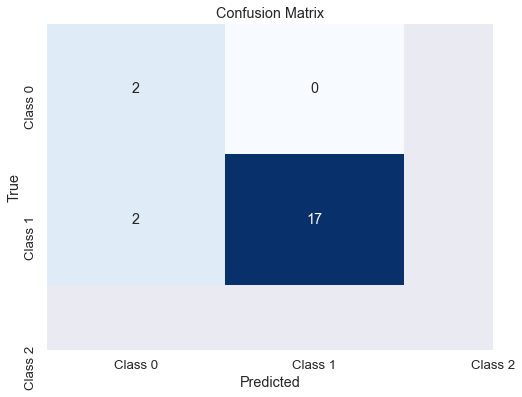

In [27]:
def plot_confusion_matrix(confusion_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define your class labels if you have a classification problem
class_labels = ['Class 0', 'Class 1', 'Class 2']  # Modify this as per your specific problem

plot_confusion_matrix(cm, class_labels)

## Chemprop comparison

In [21]:
# This script shows the Chemprop training process of one folder (train-validation dataset pair).
# Please use the same method to train Chemprop models on other datasets. 

arguments = [
    '--data_path', os.path.join(folder_dir, 'train.csv'),
    '--separate_test_path', os.path.join(folder_dir, 'train.csv'),
    '--separate_val_path', os.path.join(folder_dir, 'valid.csv'),
    '--smiles_columns', 'smiles',
    '--target_columns', 'target',
    '--dataset_type', 'multiclass',
    '--multiclass_num_classes', '3',
    '--save_dir', os.path.join(folder_dir, 'model_checkpoint')
]

args = chemprop.args.TrainArgs().parse_args(arguments)
mean_score, std_score = chemprop.train.cross_validate(args=args, train_func=chemprop.train.run_training)
print(mean_score, std_score)

## Troisi dataset GPT-3.5 embeddings & UMAP 2-D visualization

In [28]:
# get GPT-3.5 embeddings

def get_embedding(text, model="text-embedding-ada-002"):
    text = text.replace("\n", " ")
    return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']


embeddings = []

for i in range(len(test)):
    # print(test.iloc[i]['prompt'])
    prompt = test.iloc[i]['prompt']
    embedding = get_embedding(prompt)
    embeddings.append(embedding)
    if i == 20:
        break

In [30]:
import umap
import matplotlib.pyplot as plt

X = np.array(embeddings)
reducer = umap.UMAP(n_neighbors=15, n_components=2)
reduced_embedding = reducer.fit_transform(X)

C:\Users\darkn\anaconda3\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


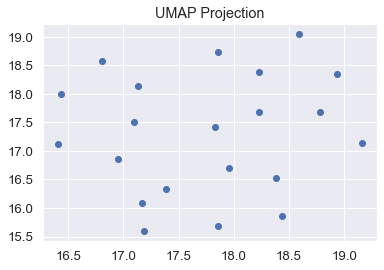

In [33]:
import matplotlib.pyplot as plt

plt.scatter(reduced_embedding[:, 0], reduced_embedding[:, 1])
plt.title("UMAP Projection")
plt.show()

# 3. Experiment Results Collection & Visualization

## Chemprop result collection

In [ ]:
PATH = r'C:\Users\darkn\PycharmProjects\ChemGPT\out\new_data_gpt\small_molecule'
folders = os.listdir(PATH)

results_chemprop = {}

# for folder in os.listdir(PATH):
for folder in folders:
    if not os.path.exists(os.path.join(PATH, folder + '/model_checkpoint/fold_0')):
        continue
    
    arguments = [
        '--test_path', os.path.join(PATH, folder + '/valid.csv'),  # 
        '--checkpoint_dir', os.path.join(PATH, folder + '/model_checkpoint/fold_0'),
        '--preds_path',  os.path.join(PATH, folder + '/pred.csv')
    ]
    args = chemprop.args.PredictArgs().parse_args(arguments)
    model_objects = chemprop.train.load_model(args=args)
    
    
    preds = chemprop.train.make_predictions(args=args, model_objects=model_objects)
    
    df = pd.read_csv(os.path.join(PATH, folder + '/valid.csv'))
    y_true = df['target'].to_list()
    y_pred = []
    correct = 0
    total = 0
    for i, pred in enumerate(preds):
        total += 1
        p = np.argmax(pred)
        y_pred.append(p)
        if p == y_true[i]:
            correct += 1
    print (folder, ': ', correct/total)
    results_chemprop[folder] = correct/total

In [ ]:
homo_result_chemprop = {}
lumo_result_chemprop = {}

splits = ['0.2', '0.4', '0.6', '0.8']

for split in splits:
    keys = [key for key in results_chemprop.keys() if split in key and 'HOMO' in key]
    total = 0
    for key in keys:
        total += results_chemprop[key]
    total = total / 3
    homo_result_chemprop[split] = total
    
    keys = [key for key in results_chemprop.keys() if split in key and 'LUMO' in key]
    total = 0
    for key in keys:
        total += results_chemprop[key]
    total = total / 3
    lumo_result_chemprop[split] = total

print(homo_result_chemprop, lumo_result_chemprop)

In [ ]:
PATH = r'C:\Users\darkn\PycharmProjects\ChemGPT\out\new_data_gpt\small_molecule_small_dataset'
folders = os.listdir(PATH)

results_chemprop = {}

# for folder in os.listdir(PATH):
for folder in folders:
    if not os.path.exists(os.path.join(PATH, folder + '/model_checkpoint/fold_0')):
        continue
    
    arguments = [
        '--test_path', os.path.join(PATH, folder + '/valid.csv'),  # 
        '--checkpoint_dir', os.path.join(PATH, folder + '/model_checkpoint/fold_0'),
        '--preds_path',  os.path.join(PATH, folder + '/pred.csv')
    ]
    args = chemprop.args.PredictArgs().parse_args(arguments)
    model_objects = chemprop.train.load_model(args=args)
    
    
    preds = chemprop.train.make_predictions(args=args, model_objects=model_objects)
    
    df = pd.read_csv(os.path.join(PATH, folder + '/valid.csv'))
    y_true = df['target'].to_list()
    y_pred = []
    correct = 0
    total = 0
    for i, pred in enumerate(preds):
        total += 1
        p = np.argmax(pred)
        y_pred.append(p)
        if p == y_true[i]:
            correct += 1
    print (folder, ': ', correct/total)
    results_chemprop[folder] = correct/total

In [ ]:
homo_result_chemprop = {}
lumo_result_chemprop = {}

splits = ['0.01', '0.02', '0.1']

for split in splits:
    keys = [key for key in results_chemprop.keys() if split in key and 'HOMO' in key]
    total = 0
    for key in keys:
        total += results_chemprop[key]
    total = total / 3
    homo_result_chemprop[split] = total
    
    keys = [key for key in results_chemprop.keys() if split in key and 'LUMO' in key]
    total = 0
    for key in keys:
        total += results_chemprop[key]
    total = total / 3
    lumo_result_chemprop[split] = total

print(homo_result_chemprop, lumo_result_chemprop)

In [ ]:
PATH = r'C:\Users\darkn\PycharmProjects\ChemGPT\out\new_data_gpt'
folders = os.listdir(PATH)

results_chemprop = {}

# for folder in os.listdir(PATH):
for folder in folders:
    if not os.path.exists(os.path.join(PATH, folder + '/model_checkpoint/fold_0')):
        continue
    
    arguments = [
        '--test_path', os.path.join(PATH, folder + '/valid.csv'),  # 
        '--checkpoint_dir', os.path.join(PATH, folder + '/model_checkpoint/fold_0'),
        '--preds_path',  os.path.join(PATH, folder + '/pred.csv')
    ]
    args = chemprop.args.PredictArgs().parse_args(arguments)
    model_objects = chemprop.train.load_model(args=args)
    
    
    preds = chemprop.train.make_predictions(args=args, model_objects=model_objects)
    
    df = pd.read_csv(os.path.join(PATH, folder + '/valid.csv'))
    y_true = df['target'].to_list()
    y_pred = []
    correct = 0
    total = 0
    for i, pred in enumerate(preds):
        total += 1
        p = np.argmax(pred)
        y_pred.append(p)
        if p == y_true[i]:
            correct += 1
    print (folder, ': ', correct/total)
    results_chemprop[folder] = correct/total

# 4. Ablation Studies

## Ablation: Combine core data

In [ ]:
CORE_LISTS = [
    ['core_16392',
     'core_16404',
     'core_16583',
     'core_14647',
     'core_14707'
    ], 
    ['core_7123',
     'core_7188',
     'core_8000'
    ],
    ['core_11149',
     'core_11127',
     'core_11138'
    ],
    ['core_16392',
     'core_16404',
     'core_16583',
     'core_14647',
     'core_14707',
     'core_7123',
     'core_7188',
     'core_8000'
    ],
    ['core_16392',
     'core_16404',
     'core_16583',
     'core_14647',
     'core_14707',
     'core_7123',
     'core_7188',
     'core_8000',
     'core_11149',
     'core_11127',
     'core_11138'
    ]
]

NAME_POSTFIXS = [
    '12345',
    '678',
    '91011',
    '12345678',
    'all'
]

BASE_DIR = r'C:\Users\darkn\PycharmProjects\ChemGPT\out\new_data_gpt\ablation'

TYPES = ['LUMO', 'HOMO']

def generate_core_combination_data(CORE_LIST, NAME):
    for TYPE in TYPES:
        test_list = []
        for folder in os.listdir(BASE_DIR):
            for df_name in CORE_LIST:
                if TYPE in folder and df_name in folder:
                    df = pd.read_csv(os.path.join(BASE_DIR, folder + '/valid.csv'))
                    test_list.append(df)
                    path = os.path.join(BASE_DIR, folder)
        test_df = pd.concat(test_list)

        train_df = pd.read_csv(os.path.join(path, 'train.csv'))
        duplicate = train_df.merge(test_df, on=['smiles', 'target'])
        train_df = train_df.append(duplicate)
        train_df = train_df.drop_duplicates(subset='smiles', keep=False)
        train_df.columns = ['prompt', 'completion']
        test_df.columns = ['prompt', 'completion']
        train_df['completion'] = train_df['completion'].astype(str)
        test_df['completion'] = test_df['completion'].astype(str)
        train_df.to_csv('train_core_{}_{}.csv'.format(TYPE, NAME), index=False)
        test_df.to_csv('test_core_{}_{}.csv'.format(TYPE, NAME), index=False)
        write_file(train_df, test_df, '{}_{}'.format(TYPE, NAME))
        
for CORE_LIST, NAME in zip(CORE_LISTS, NAME_POSTFIXS):
    generate_core_combination_data(CORE_LIST, NAME)

## SmilesEnumerator Replacement

In [ ]:
# Test if GPT-3.5 model is consistent to equivalent 

from SmilesEnumerator import SmilesEnumerator
sme = SmilesEnumerator()

MODEL = ''
base_dir = ''

with open(os.path.join(base_dir, 'valid.jsonl'), 'r') as json_file:
    json_list = list(json_file)

randomized_smiles = []
real_smiles = []
real_class = []
pred_class = []
randomized_class = []

for json_str in json_list:
    pair = json.loads(json_str)
    print(pair)
    smile = pair['prompt']
    
    try:
        result = openai.Completion.create(model=MODEL, prompt=pair['prompt'], max_tokens=1, temperature=0)
        random_smile = sme.randomize_smiles(smile)
        result_randomized = openai.Completion.create(model=MODEL, prompt=random_smile, max_tokens=1, temperature=0)

        randomized_smiles.append(random_smile)
        real_smiles.append(smile)
        real_class.append(pair['completion'])
        pred_class.append(result['choices'][0]['text'])
        randomized_class.append(result_randomized['choices'][0]['text'])
    except:
        pass

## Atom Replacement Test

## Functional Group Ablation Test